In [1]:
!pip install torch torchaudio transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
!pip install torchviz

In [3]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.3 MB/s eta 0:00:00


In [4]:
!pip install torchsummary

In [5]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 88.7 MB/s eta 0:00:00


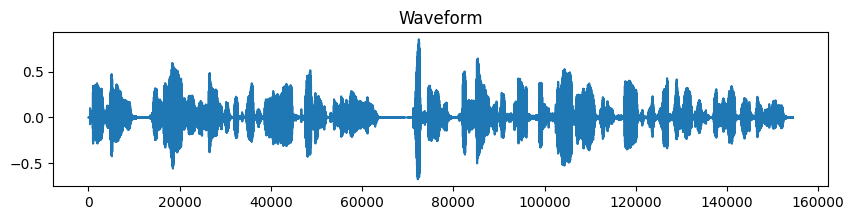

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from jiwer import wer
import os

# Load and Resample Audio
audio_path = "/content/LJ001-0001.wav"
waveform, sample_rate = torchaudio.load(audio_path)

if sample_rate != 16000:
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = resampler(waveform)
    sample_rate = 16000

# Plot waveform
plt.figure(figsize=(10, 2))
plt.plot(waveform.t().numpy())
plt.title("Waveform")
plt.show()

# Load Pretrained Model and Processor for Wav2Vec2
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()
print(model)

# Inference
inputs = processor(waveform.squeeze().numpy(), sampling_rate=sample_rate, return_tensors="pt", padding=True)
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

pred_ids = torch.argmax(logits, dim=-1)
transcription = processor.decode(pred_ids[0])
print("Transcription Output (Wav2Vec2):")
print(transcription)

# Word Error Rate (WER) Calculation with the reference sequence as ground truth
reference = "Printing in the only sense with which we are at present concerned differs from most if not from all the arts and crafts represented in the Exhibition"
hypothesis = transcription

error = wer(reference.lower(), hypothesis.lower())
print("Word Error Rate (WER)",error)

# Export Full Model as ONNX for Netron visualization
onnx_path = "wav2vec2.onnx"
torch.onnx.export(model,
                  (inputs["input_values"],),
                  onnx_path,
                  input_names=["input_values"],
                  output_names=["logits"],
                  dynamic_axes={"input_values": {0: "batch_size", 1: "sequence"}},
                  opset_version=17)
print(f"ONNX model saved as '{onnx_path}' — load this in Netron (https://netron.app) to see full architecture.")
from google.colab import files
files.download("wav2vec2.onnx")

In [8]:
#Conformer architecture
from transformers import Wav2Vec2Processor, Wav2Vec2ConformerForCTC
model_name = "facebook/wav2vec2-conformer-rope-large-960h-ft"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ConformerForCTC.from_pretrained(model_name)
model.eval()
print(model)

#Inference
inputs = processor(waveform.squeeze().numpy(), sampling_rate=sample_rate, return_tensors="pt", padding=True)
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

pred_ids = torch.argmax(logits, dim=-1)
transcription = processor.decode(pred_ids[0])
print("Transcription Output (Conformer):")
print(transcription)

# Word Error Rate (WER) calculation
reference = "Printing in the only sense with which we are at present concerned differs from most if not from all the arts and crafts represented in the Exhibition"
error = wer(reference.lower(), transcription.lower())
print("Word Error Rate (WER):", error)

# Exporting to ONNX
onnx_path = "wav2vec2_conformer.onnx"
torch.onnx.export(model,
                  (inputs["input_values"],),
                  onnx_path,
                  input_names=["input_values"],
                  output_names=["logits"],
                  dynamic_axes={"input_values": {0: "batch_size", 1: "sequence"}} if inputs["input_values"].shape[0] is None else {},
                  opset_version=17)
print(f"ONNX model saved as '{onnx_path}' — open in https://netron.app to view full architecture.")
from google.colab import files
files.download("wav2vec2_conformer.onnx")

preprocessor_config.json:   0%|          | 0.00/254 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.37G [00:00<?, ?B/s]

Wav2Vec2ConformerForCTC(
  (wav2vec2_conformer): Wav2Vec2ConformerModel(
    (feature_extractor): Wav2Vec2ConformerFeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2ConformerLayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2ConformerLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2ConformerLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2ConformerFeatureProjection(
      (layer_n

/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2_conformer/modeling_wav2vec2_conformer.py:163: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sequence_length == self.cached_sequence_length and self.cached_rotary_positional_embedding is not None:


ONNX model saved as 'wav2vec2_conformer.onnx' — open in https://netron.app to view full architecture.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>